## Linear Regression with eaget api  (立即执行)

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import tensorflow.contrib.eager as tfe

/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
tfe.enable_eager_execution()

In [3]:
# Training Data
train_X = [3.3, 4.4, 5.5, 6.71, 6.93, 4.168, 9.779, 6.182, 7.59, 2.167,
           7.042, 10.791, 5.313, 7.997, 5.654, 9.27, 3.1]
train_Y = [1.7, 2.76, 2.09, 3.19, 1.694, 1.573, 3.366, 2.596, 2.53, 1.221,
           2.827, 3.465, 1.65, 2.904, 2.42, 2.94, 1.3]
n_samples = len(train_X)

# Parameters
learning_rate = 0.01
display_step = 100
num_steps = 1000

In [4]:
W = tfe.Variable(np.random.randn())
b = tfe.Variable(np.random.randn())

def linear_regerssion(inputs):
    return inputs * W + b

def mean_square_fn(model_fn, inputs, labels):
    return tf.reduce_sum(tf.pow(model_fn(inputs) - labels, 2) / (2* n_samples))

In [5]:
#随机梯度下降优化器
optimizer = tf.train.GradientDescentOptimizer(learning_rate=learning_rate)

# 计算梯度
grad = tfe.implicit_gradients(mean_square_fn)

In [6]:
print("Ininial cost={:.9f}".format(mean_square_fn(linear_regerssion, train_X, train_Y)), 
     "W=", W.numpy(), "b=", b.numpy())

Ininial cost=15.235197067 W= 1.0415226 b= 1.0647599


Epoch:0100 cost= 0.078043588 W= 0.232706 b= 0.9329989
Epoch:0200 cost= 0.077803157 W= 0.23487093 b= 0.9176505
Epoch:0300 cost= 0.077614613 W= 0.23678824 b= 0.9040576
Epoch:0400 cost= 0.077466711 W= 0.23848626 b= 0.8920194
Epoch:0500 cost= 0.077350713 W= 0.2399901 b= 0.88135797
Epoch:0600 cost= 0.077259734 W= 0.2413219 b= 0.87191594
Epoch:0700 cost= 0.077188373 W= 0.24250142 b= 0.86355376
Epoch:0800 cost= 0.077132404 W= 0.24354602 b= 0.85614806
Epoch:0900 cost= 0.077088505 W= 0.24447113 b= 0.8495893
Epoch:1000 cost= 0.077054068 W= 0.24529046 b= 0.8437807


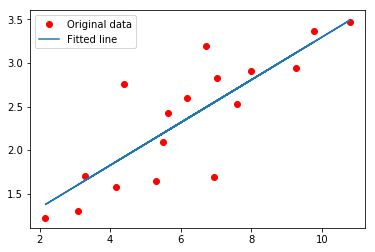

In [7]:
# 训练
for step in range(num_steps):
    optimizer.apply_gradients(grad(linear_regerssion, train_X, train_Y))
    if (step + 1) % display_step == 0:
        print("Epoch:" '%04d' % (step + 1), "cost=", "{:.9f}".format(mean_square_fn(linear_regerssion, 
                                                                                   train_X, train_Y)),
             "W=", W.numpy(), "b=", b.numpy())
# Graphic display
plt.plot(train_X, train_Y, 'ro', label='Original data')
plt.plot(train_X, np.array(W * train_X + b), label='Fitted line')
plt.legend()
plt.show()

## 逻辑回归识别手写数字

In [8]:
from __future__ import absolute_import, division, print_function

import tensorflow as tf
import tensorflow.contrib.eager as tfe

In [9]:
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("/tmp/data", one_hot=False)

Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
Instructions for updating:
Please write your own downloading logic.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting /tmp/data/train-images-idx3-ubyte.gz
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting /tmp/data/train-labels-idx1-ubyte.gz
Extracting /tmp/data/t10k-images-idx3-ubyte.gz
Extracting /tmp/data/t10k-labels-idx1-ubyte.gz
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.


In [10]:
# 参数
learning_rate = 0.1
batch_size = 128
num_steps = 1000
display_step = 100

In [11]:
dataset = tf.data.Dataset.from_tensor_slices((mnist.train.images, mnist.train.labels)).batch(batch_size)

In [13]:
dataset_iter = tfe.Iterator(dataset)

In [16]:
W = tfe.Variable(tf.zeros([784, 10]), name="weights")
b = tfe.Variable(tf.zeros([10]), name="bias")

In [17]:
def logistic_regression(inputs):
    return tf.matmul(inputs, W) + b

In [18]:
def loss_fn(inference_fn, inputs, labels):
    # 使用交叉熵
    return tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(
        logits=inference_fn(inputs), labels=labels))

In [19]:
# 计算精确度
def accuracy_fn(inference_fn, inputs, labels):
    prediction = tf.nn.softmax(inference_fn(inputs))
    correct_pred = tf.equal(tf.argmax(prediction, 1), labels)
    return tf.reduce_mean(tf.cast(correct_pred, tf.float32))

In [20]:
# 随机梯度优化
optimizer = tf.train.GradientDescentOptimizer(learning_rate=learning_rate)

grad = tfe.implicit_gradients(loss_fn)

In [21]:
# 训练
average_loss = 0.
average_acc = 0.
for step in range(num_steps):
    try:
        d = dataset_iter.next()
    except StopIteration:
        dataset_iter = tfe.Iterator(dataset)
        d = dataset_iter.next()
    x_batch = d[0]
    y_batch = tf.cast(d[1], dtype=tf.int64)
    
    # 计算batch的损失
    batch_loss = loss_fn(logistic_regression, x_batch, y_batch)
    average_loss += batch_loss
    # 计算batch精确度
    batch_accutacy = accuracy_fn(logistic_regression, x_batch, y_batch)
    average_acc += batch_accutacy
    
    if step == 0:
        print("Initial loss={:.9f}".format(average_loss))
    optimizer.apply_gradients(grad(logistic_regression, x_batch, y_batch))
    
       # Display info
    if (step + 1) % display_step == 0 or step == 0:
        if step > 0:
            average_loss /= display_step
            average_acc /= display_step
        print("Step:", '%04d' % (step + 1), " loss=",
              "{:.9f}".format(average_loss), " accuracy=",
              "{:.4f}".format(average_acc))
        average_loss = 0.
        average_acc = 0.

Initial loss=2.302585363
Step: 0001  loss= 2.302585363  accuracy= 0.1172
Step: 0100  loss= 0.952338457  accuracy= 0.7955
Step: 0200  loss= 0.535867453  accuracy= 0.8712
Step: 0300  loss= 0.485415280  accuracy= 0.8757
Step: 0400  loss= 0.433947206  accuracy= 0.8843
Step: 0500  loss= 0.381990701  accuracy= 0.8971
Step: 0600  loss= 0.394154936  accuracy= 0.8947
Step: 0700  loss= 0.391497582  accuracy= 0.8905
Step: 0800  loss= 0.386373103  accuracy= 0.8945
Step: 0900  loss= 0.332039326  accuracy= 0.9096
Step: 1000  loss= 0.358993769  accuracy= 0.9002


In [22]:

# Evaluate model on the test image set# Evalu 
testX = mnist.test.images
testY = mnist.test.labels

test_acc = accuracy_fn(logistic_regression, testX, testY)
print("Testset Accuracy: {:.4f}".format(test_acc))

Testset Accuracy: 0.9083
